# MoE Brainy - Training
In this notebook we're going to look at how MoE Brainy is trained.

Specifically, we'll examine what happens during a single representative `epoch`, in this case `epoch = 3`.

We won't be using actual image information though -- we'll be examining the training code that is run ***after*** the gating network has already determined which experts should be used for each image in the mini batch.

Also, we will use mock Experts that generate pre-calculated outputs.

Finally, in this example, our mini batch is assumed to contain only 4 images. Normally a mini batch contains 64 images, however by using 4 we will be able to more easily examine the intermediate outputs created by the training code.

Much of the training code focuses on vectorizing our data so that we can maximize the parallelism of GPUs.

## Use Bash Instead of PowerShell in Jupyter Lab on Windows
Note: On Windows, you get can get a bash terminal working inside Jupyter Lab.

1. Make sure you have a full Git installed (e.g.: that includes `winpty` and `bash`)
2. Create a file (if it does not already exist) called `jupyter_notebook_config.py` in the `C:\Users\{username}\.jupyter` folder
3. Add the code below into this file:

```python
c = get_config()
c.ServerApp.terminado_settings = {
    "shell_command": ["C:/Program Files/Git/usr/bin/winpty.exe", "C:/Program Files/Git/usr/bin/bash.exe", "--login", "-i"]
}
```

4. Double the check that the files referenced above exist, but these are their standard locations.
5. If currently in Jupyter Lab, go to `File > Shutdown`
6. Restart Jupyter Lab

Now when you open a Terminal tab, you will be using bash instead of PowerShell


# Environment Setup - Windows

## Git and Python

Ensure the latest versions of git and python are installed. As of time of writing, PyTorch requires at least Python 3.9 or later.

- Python
  - https://www.python.org/downloads/windows/
- Git
  - https://git-scm.com/downloads/win


## CUDA

First make sure your nVidia drivers are up to date. Then

1. You will need to find out what versions of CUDA are supported by PyTorch
2. You need to find out what versions of CUDA are supported by your GPU

Ensure you download a version of CUDA that is both
  - a. supported by your GPU, and
  - b. supported by PyTorch

At the time of writing this, PyTorch supports

- CUDA 11.8
- CUDA 12.6
- CUDA 12.8

So install the latest version of CUDA that your GPU supports

### Finding CUDA drivers

- Older versions of CUDA (for older nVidia GPUs like my GTX 960m)
  - https://developer.nvidia.com/cuda-toolkit-archive
- CUDA Version 11.8 (the specific version I use)
  - Download: https://developer.nvidia.com/cuda-11-8-0-download-archive
  - Docs: https://docs.nvidia.com/cuda/archive/11.8.0/
- For newer nVidia GPUs
  - https://developer.nvidia.com/cuda-toolkit

1. Open a command line in git-bash. Its a good idea to put this in your Windows PATH.

```bash
"C:\Program Files\Git\git-bash.exe"
```

## Install

```bash
# clone Brainy
git clone https://github.com/miklish/brainy
cd brainy

# create and activate your environment
python -m venv .venv
source .venv/Scripts/activate

# install pytorch - this is the commad for PyTorch 2.7 with CUDA 11.8
# get your specific command here: https://pytorch.org/
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Jupter Notebooks support
pip install jupyterlab

# Support for graphing
pip install matplotlib
```

## Reusing Environments
If you have multiple repositories that use the same PyTorch setup, they can share an environment. For example, if I have the following folder structure

- ~
  - myrepos
    - brainy
    - new-proj

Then if I originally setup the environment in `myrepos/brainy` and want to use that in `myrepos/new-proj`, then all I need to do is

```bash
source ../brainy/.venv/Scripts/activate
```


# Setup

In [48]:
import torch

MINI_BATCH_SIZE = 4
NUM_EXPERTS = 6
TOP_K = 3

torch.set_printoptions(
    precision=2,       # Number of decimal places
    threshold=1000,    # Max number of elements to show
    edgeitems=3,       # Number of elements to show at start/end of each dimension
    linewidth=120,     # Max width of each line
    sci_mode=False     # Use scientific notation
)

To simplify the notebook, we're going to create a mock Expert and code it to return a mock set of unactivated predictions (logits) -- one prediction for each digit for each image.

We will then instantiate 6 such fake experts for use later on.

In [49]:
class FakeExpert:
  def __init__(self, expert_num):
    self.expert_num = expert_num

  def forward(self, mini_batch_size):
    return 10 * torch.rand(mini_batch_size, 10)

  def __call__(self, *args, **kwargs):
    return self.forward(args[0])

experts = [FakeExpert(e) for e in range(NUM_EXPERTS)]

Now, into the main algorithm.

The line of code below executes at the start of each epoch. This helps implement the `gradual detachment` idea described in the `README.MD`.

In [50]:
epoch = 3
current_top_k = max(TOP_K, NUM_EXPERTS - epoch)

The `gating_outputs` tensor contains the gating network's score for 6 experts on each of the 4 images in the mini batch.

- dim=0: This is the index dimension for the images
- dim=1: This is the index dimension for the the experts

In [51]:
gating_outputs = torch.tensor([
# expert:   0     1     2     3     4     5
          [0.30, 0.20, 0.10, 0.25, 0.10, 0.05],  # image 0
          [0.05, 0.45, 0.30, 0.05, 0.05, 0.10],  # image 1
          [0.10, 0.10, 0.05, 0.50, 0.15, 0.10],  # image 2
          [0.25, 0.05, 0.20, 0.10, 0.10, 0.30]   # image 3
])

The code below creates a tensor `top_k_indices` that gathers the expert indices (dimension 1 indices) of the top 3 results for each image. So

- dim=0: image indices
- dim=1: the top `current_top_k` expert indices for the image
  - note: each image may have a different set of `current_top_k` experts

In [52]:
_, top_k_indices = torch.topk(input=gating_outputs, k=current_top_k, dim=1)

print(top_k_indices)

tensor([[0, 3, 1],
        [1, 2, 5],
        [3, 4, 0],
        [5, 0, 2]])


We then create the `mask` tensor which will be used to zero-out any gating results for non-top-k experts. This is important since we are going to normalize the gating network's results so it provides a probability distribution over only the top-k experts.

So, step 1 is to create a mask tensor that contains only zeros. This initial zero'd-out mask has the following shape:

- dim=0: image indices
- dim=1: expert mask indices

In [53]:
mask = torch.zeros_like(gating_outputs)

print("mask:")
print(mask)

mask:
tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])


Recall that this tensor is indexed as follows: `[image_index, expert_index]`.

What we want to do is set `mask[i,e]` to `1` if expert `e` is one of the top-k experts for image `i`.

The `scatter_` method does the equivalent of the following code:

```python
for i in range(top_k_indices.size(0)): # over all indices in dim=0
  for e in top_k_indices[i]: # over a subset of indices in dim=1
    mask[i, e] = 1
```

Note that we set `dim=1` in the call to `scatter_` since `dim=1` specifies the 'independent' coordinate, which in this case is `e`.

## Side notes on tensor shapes as index sets (feel free to ignore)

As an example of what the `dim` argument in `scatter_()` means, consider the example of a 4d tensor `t` and assume we set `dim=1` in the call to `scatter_()`. This means that we range over all indexes in all dimensions of the `target` $t$ less dimension `1`. Specifically, we'd range over all indexes

$\quad\quad d_0 = [0,..,t.size(0) - 1] \times d_2 = [0,..,t.size(2) - 1] \times d_3 = [0,..,t.size(3) - 1]$

However, we only range over a *subset* of indexes in $d_1$ (dimension 1), where

$\quad\quad d_1 = [0,..,t.size(1) - 1]$.

In fact, for each point $(i_0,i_2,i_3)$ in $d_0 \times d_2 \times d_3$, there is a subset of $d_1$.

Let $d'_1(i_0,i_2,i_3)$ be this *subset* of indexes in $d_1$, and let $\overline{d'_1}(i_0,i_2,i_3)$ be its complement, then if the `mask` is the target, then it is defined as the tensor:

$\quad\quad mask[i_0,i_1,i_2,i_3] = \begin{cases}
      1 & (i_0,i_1,i_2,i_3) \in d_0 \times d'_1(i_0,i_2,i_3) \times d_2 \times d_3 \\
      0 & (i_0,i_1,i_2,i_3) \in d_0 \times \overline{d'_1}(i_0,i_2,i_3) \times d_2 \times d_3
   \end{cases}
$

More generally, we can create n partitions of the mask with n functions $d_{0},...d_{n-1}$.

$\quad\quad mask[i_0,i_1,i_2,i_3] = \begin{cases}
      n-1 & (i_0,i_1,i_2,i_3) \in d_0 \times d_{1,n-1}(i_0,i_2,i_3) \times d_2 \times d_3 \\
      ... & \\
      0 & (i_0,i_1,i_2,i_3) \in d_0 \times d_{1,0}(i_0,i_2,i_3) \times d_2 \times d_3
   \end{cases}
$

## Overkill on this topic... (feel free to ignore)

In fact, one could consider the set $d_0 \times d_2 \times d_3$ to be a seperate space $S$. Elements of $S$ would be discrete vectors $\overline{s}$.

So, if we have $S = d_0 \times d_2 \times d_3$, and a map $d:S \to d_1$, then

$\quad\quad mask[\overline{s},i] = \begin{cases}
      1 & (\overline{s},i) \in S \times d'_1(\overline{s}) \\      
      0 & (\overline{s},i) \in S \times \overline{d'_1}(\overline{s})
   \end{cases}
$

More generally,

$\quad\quad mask_{1}[\overline{s},i]_{D} = \begin{cases}
      n-1 & (\overline{s},i) \in S \times d_{D,0}(\overline{s}) \\
      ... & \\
      0 & (\overline{s},i) \in S \times d_{D,n-1}(\overline{s})
   \end{cases}
$

=

$\quad\quad mask_{D}[\overline{s},i] = \begin{cases}
      k & (\overline{s},i) \in S \times d_{D,k}(\overline{s})
   \end{cases}
$

## Equivalent of scatter_()

In the 4D case, scatter looks like this in Python:

```python
for d0 in range(top_k_indices.size(0)):
  for d2 in range(top_k_indices.size(2)):
    for d3 in range(top_k_indices.size(3)):
      for d1_prime in top_k_indices[d0, :, d2, d3]:
        mask[d0, d1_prime, d2, d3] = 1.0
```

In [57]:
for d0 in range(top_k_indices.size(0)): # over all indices in dim=0
  for d1_prime in top_k_indices[d0,:]: # over a subset of indices in dim=1
    mask[d0, d1_prime] = 1

print(f"top_k_indices:\n{top_k_indices}\n")
print(f"mask:\n{mask}")

top_k_indices:
tensor([[0, 3, 1],
        [1, 2, 5],
        [3, 4, 0],
        [5, 0, 2]])

mask:
tensor([[1., 1., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 0., 1.]])


We then do an element-wise multiplication of the `gating_outputs` by the `mask` to zero-out the non-expert scores.

An element-wise mult (when the tensor shapes are the same) is equvalent to

```python
for i in range(mask.size(0)):
  for j in range(mask.size(1)):
    gating_outputs_mask[i,j] = gating_outputs[i,j] * mask[i,j]
```

In [9]:
print(f"gating_outputs\n{gating_outputs}")
print()

gating_outputs_mask = gating_outputs * mask
print(f"gating_outputs_mask\n{gating_outputs_mask}")

gating_outputs
tensor([[0.30, 0.20, 0.10, 0.25, 0.10, 0.05],
        [0.05, 0.45, 0.30, 0.05, 0.05, 0.10],
        [0.10, 0.10, 0.05, 0.50, 0.15, 0.10],
        [0.25, 0.05, 0.20, 0.10, 0.10, 0.30]])

gating_outputs_mask
tensor([[0.30, 0.20, 0.00, 0.25, 0.00, 0.00],
        [0.00, 0.45, 0.30, 0.00, 0.00, 0.10],
        [0.10, 0.00, 0.00, 0.50, 0.15, 0.00],
        [0.25, 0.00, 0.20, 0.00, 0.00, 0.30]])


Next, we sum the results for each image across all top k experts. This will be used as the denominator for the results for each image in order to normalize the results.

\
**gating_outputs_sum = gating_outputs_mask.sum(dim=1, keepdim=True)**


`gating_outputs_mask` indexes are `[image_index, expert_index]`. Note that we set `dim=1` since the values we want to sum are the expert scores which are indexed in `dim=1`.

We use the `keepdim=True` option to ensure that the dimension `gating_outputs_sum` is the same as `gating_outputs_mask` -- specifically, that it stays 2D.

However, while the dimension of `gating_outputs_sum` is still the same (2D) as `gating_outputs_mask`-- the shape has changed, since we have summed the values in `dim=1` which reduces the size of `dim=1` from `6` (the original 6 expert values) to `1` (the sum of the 6 expert values).

E.g.:
- `gating_outputs_mask` has shape `[image_index, expert_index]`
- `gating_outputs_sum`  has shape `[image_index, 1]`

In [10]:
gating_outputs_sum = gating_outputs_mask.sum(dim=1, keepdim=True)

print(gating_outputs_sum)
print()
print(f"shape of gating_outputs:      {gating_outputs.size()}")
print(f"shape of gating_outputs_sum:  {gating_outputs_sum.size()}")

tensor([[0.75],
        [0.85],
        [0.75],
        [0.75]])

shape of gating_outputs:      torch.Size([4, 6])
shape of gating_outputs_sum:  torch.Size([4, 1])


If we had set `keepdim=False`, then the `sum()` function would have turned this is into a 1D tensor of sums:

In [11]:
print(gating_outputs_mask.sum(dim=1, keepdim=False))

print()
print(f"shape of gating_outputs_sum when keepdim=False:  {gating_outputs_mask.sum(dim=1, keepdim=False).size()}")

tensor([0.75, 0.85, 0.75, 0.75])

shape of gating_outputs_sum when keepdim=False:  torch.Size([4])


We now do a 'broadcasted' division. Its called 'broadcasted' because the `gating_outputs_sum` size in `dim=1` is only 1, and so it needs to be repeated 6 times to match the shape of `gating_outputs_mask` in `dim=1`, so that element-wise division can work.

In [12]:
print(f"shape of gating_outputs_mask:  {gating_outputs_mask.size()}")
gating_outputs_k = gating_outputs_mask / gating_outputs_sum

print()
print(f"shape of gating_outputs_sum:  {gating_outputs_sum.size()}")
gating_outputs_k = gating_outputs_mask / gating_outputs_sum

print()
print(f"gating_outputs_k = gating_outputs_mask / gating_outputs_sum:\n{gating_outputs_k}")

print()
print(f"shap of gating_outputs_k:  {gating_outputs_k.size()}")

shape of gating_outputs_mask:  torch.Size([4, 6])

shape of gating_outputs_sum:  torch.Size([4, 1])

gating_outputs_k = gating_outputs_mask / gating_outputs_sum:
tensor([[0.40, 0.27, 0.00, 0.33, 0.00, 0.00],
        [0.00, 0.53, 0.35, 0.00, 0.00, 0.12],
        [0.13, 0.00, 0.00, 0.67, 0.20, 0.00],
        [0.33, 0.00, 0.27, 0.00, 0.00, 0.40]])

shap of gating_outputs_k:  torch.Size([4, 6])


Now we have a new probability distribution over just the top-k experts.

**e_outputs**\
`e_outputs` is a tensor used to hold all 10 outputs from each expert for each image

The shape of `e_outputs` is `[mini_batch_size, num_experts, 10] = [4, 6, 10]` in our case.

So, what this tensor will hold are the digit predictions from each top-k expert for each image.

The first step is to create a tensor with `0`'s as the digit prediction of each expert for each image.

We will later update this with the digit predictions from each top-k expert for each image, and leave the predictions from the non-top-k experts as `0` for each digit for each image.

In [13]:
e_outputs = torch.zeros(MINI_BATCH_SIZE, NUM_EXPERTS, 10)

print("e_outputs:")
print(e_outputs)

e_outputs:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 

**The Loop**\
The loop we will look at next will -- for each expert -- figure out the set of images that it is in the top-k for, and then add its digit predictions to `e_outputs`.

However, before we get into the loop we're going to look some important code that will help us do this while also taking advantage of the paralellism of GPUs.

This code allows us to determine which images each expert e is in the top-k for.

**The code**

`mask_values_for_e = mask[:, e]`

`indexes_of_images_needing_expert_e = torch.where(mask_values_for_e == 1)[0]`

**Finding the indexes of 1s**\
First let's back up and look at a more general example. Recall that our goal here is to find the indexes of 1s for expert e in the mask.

In this example we imagine that tensor_2d contains the 1s for expert e. As you will see below, tensor_2d is a 2D tensor. This means that -- in this case -- we d not have scalar indexes, but 2d indexes.

Because of this, the code `torch.where(tensor_2d > 0)` returns a tuple of 2 1D tensors. The first tensor contains the `dim=0` indexes of 1s in `tensor_2d`, and the second tensor contains the `dim=1` indexes of 1s in `tensor_2d`.

In [14]:
# Create a 2D tensor
tensor_2d = torch.tensor([[0, 1, 0, 1],
                          [1, 0, 1, 0],
                          [0, 0, 1, 1]])
print(f"tensor_2d:\n{tensor_2d}")

print()
print(f"tensor_2d: {tensor_2d.size()}")

# This returns a tuple of two tensors:
# - First tensor: dim=0 (row) indices where value > 0
# - Second tensor: dim=1 (column) indices where value > 0
print()
indices = torch.where(tensor_2d > 0)
print(f"tuple of dimension indexes:\n{indices}")

print()
d0 = indices[0]
d1 = indices[1]

for i in range(len(d0)):
    print(f"tensor_2d[{d0[i]},{d1[i]}] = {tensor_2d[d0[0], d1[0]].item()}")


tensor_2d:
tensor([[0, 1, 0, 1],
        [1, 0, 1, 0],
        [0, 0, 1, 1]])

tensor_2d: torch.Size([3, 4])

tuple of dimension indexes:
(tensor([0, 0, 1, 1, 2, 2]), tensor([1, 3, 0, 2, 2, 3]))

tensor_2d[0,1] = 1
tensor_2d[0,3] = 1
tensor_2d[1,0] = 1
tensor_2d[1,2] = 1
tensor_2d[2,2] = 1
tensor_2d[2,3] = 1


**Back to The Loop**\
With that background on how the code works out of the way, let's look at the loop from the MoE Brainy training algorithm again.

To simplify it, we're going to focus on one iteration of the loop when `e == 1`.

In [15]:
print(f"mask:")
print("         0   1   2   3   4   5   <- experts")
print(f"{mask}")

print()
mask_values_for_e = mask[:,1]
print(f"mask_values_for_e = mask[:,1]:")
print(f"{mask_values_for_e}")

mask:
         0   1   2   3   4   5   <- experts
tensor([[1., 1., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 0., 1.]])

mask_values_for_e = mask[:,1]:
tensor([1., 1., 0., 0.])


Note that, unlike `tensor_2d`, the tensor containing the 1s we need is not 2d, but 1d. Specifically, `mask_values_for_e` is a 1d tensor of 0s and 1s where:

- `mask_values_for_e[i] == 0` if e is not in the top k for image i
- `mask_values_for_e[i] == 1` if e IS in the top k for image i

Since `mask_values_for_e` is a 1D tensor, then we only need one coordinate to describe the locations of the 1s.

Hence there is only one tensor element in the tuple, which we access via `[0]`

In [16]:
print(f"torch.where(mask_values_for_e == 1):")
print(f"{torch.where(mask_values_for_e == 1)}")

print()
print(f"indexes_of_images_needing_expert_e = torch.where(mask_values_for_e == 1)[0]:")
print(f"{torch.where(mask_values_for_e == 1)[0]}")

torch.where(mask_values_for_e == 1):
(tensor([0, 1]),)

indexes_of_images_needing_expert_e = torch.where(mask_values_for_e == 1)[0]:
tensor([0, 1])


We can now continue on to look at the remainder of this loop.

In [17]:
for e in range(NUM_EXPERTS):
    print(f"loop iteration: expert = {e}:\n")

    mask_values_for_e = mask[:, e]
    indexes_of_images_needing_expert_e = torch.where(mask_values_for_e == 1)[0]

    print(f"indexes_of_images_needing_expert_e={e}:  {indexes_of_images_needing_expert_e}")

    if len(indexes_of_images_needing_expert_e) > 0:
        num_images_needing_expert_e = len(indexes_of_images_needing_expert_e)
        print(f"num_images_needing_expert_e={e} is {num_images_needing_expert_e}")

        print()

        print("outputs:")
        outputs = experts[e](num_images_needing_expert_e)
        print(f"{outputs}")

        print()

        e_outputs[indexes_of_images_needing_expert_e, e] = outputs

    print("-------\n")

loop iteration: expert = 0:

indexes_of_images_needing_expert_e=0:  tensor([0, 2, 3])
num_images_needing_expert_e=0 is 3

outputs:
tensor([[9.02, 2.06, 5.63, 0.40, 4.20, 1.17, 0.30, 7.47, 1.76, 6.89],
        [4.28, 8.81, 1.86, 5.46, 4.33, 0.57, 6.08, 7.49, 8.86, 7.35],
        [5.57, 7.02, 7.76, 2.08, 4.06, 8.11, 1.76, 7.73, 3.83, 8.89]])

-------

loop iteration: expert = 1:

indexes_of_images_needing_expert_e=1:  tensor([0, 1])
num_images_needing_expert_e=1 is 2

outputs:
tensor([[6.40, 3.91, 4.93, 2.85, 6.55, 7.35, 9.74, 8.39, 0.51, 4.86],
        [1.11, 0.75, 6.12, 2.68, 6.49, 5.16, 1.88, 6.21, 3.16, 7.58]])

-------

loop iteration: expert = 2:

indexes_of_images_needing_expert_e=2:  tensor([1, 3])
num_images_needing_expert_e=2 is 2

outputs:
tensor([[2.28, 5.59, 1.56, 2.68, 2.65, 9.33, 8.80, 0.80, 1.03, 7.96],
        [1.56, 2.20, 0.73, 5.62, 8.58, 5.79, 6.13, 6.23, 2.52, 2.45]])

-------

loop iteration: expert = 3:

indexes_of_images_needing_expert_e=3:  tensor([0, 2])
num_ima

So let's look at the results. For example, expert 4 we have

```python
loop iteration: expert = 4:

indexes_of_images_needing_expert_e=4:  tensor([2])
num_images_needing_expert_e=4 is 1

outputs:
tensor([[9.07, 8.90, 9.48, 4.50, 2.26, 9.11, 9.32, 2.69, 0.98, 9.20]])
```

This means that there is only one image from the batch that expert 4 is the expert for. The outputs are its logits for this image. The index of the image its an expert for is 2.

From the code we see that

```python
e_outputs[indexes_of_images_needing_expert_e, e] = outputs
```

This means we replace `e_outputs[2]` with `[9.07, 8.90, 9.48, 4.50, 2.26, 9.11, 9.32, 2.69, 0.98, 9.20]` (expert 4's output).

In [18]:
print(e_outputs)

tensor([[[9.02, 2.06, 5.63, 0.40, 4.20, 1.17, 0.30, 7.47, 1.76, 6.89],
         [6.40, 3.91, 4.93, 2.85, 6.55, 7.35, 9.74, 8.39, 0.51, 4.86],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [8.28, 6.71, 8.82, 9.05, 1.84, 5.18, 4.30, 0.49, 6.16, 7.57],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]],

        [[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [1.11, 0.75, 6.12, 2.68, 6.49, 5.16, 1.88, 6.21, 3.16, 7.58],
         [2.28, 5.59, 1.56, 2.68, 2.65, 9.33, 8.80, 0.80, 1.03, 7.96],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [8.03, 4.08, 1.78, 7.28, 1.53, 5.91, 3.16, 4.84, 1.12, 8.15]],

        [[4.28, 8.81, 1.86, 5.46, 4.33, 0.57, 6.08, 7.49, 8.86, 7.35],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
  

In [19]:
print(f"gating_outputs_k\n{gating_outputs_k.size()}\n{gating_outputs_k}")

gate_confidence = gating_outputs_k.unsqueeze(2)
print(f"\ngate_confidence = gating_outputs_k.unsqueeze(2)\n{gate_confidence.size()}\n{gate_confidence}")

gating_outputs_k
torch.Size([4, 6])
tensor([[0.40, 0.27, 0.00, 0.33, 0.00, 0.00],
        [0.00, 0.53, 0.35, 0.00, 0.00, 0.12],
        [0.13, 0.00, 0.00, 0.67, 0.20, 0.00],
        [0.33, 0.00, 0.27, 0.00, 0.00, 0.40]])

gate_confidence = gating_outputs_k.unsqueeze(2)
torch.Size([4, 6, 1])
tensor([[[0.40],
         [0.27],
         [0.00],
         [0.33],
         [0.00],
         [0.00]],

        [[0.00],
         [0.53],
         [0.35],
         [0.00],
         [0.00],
         [0.12]],

        [[0.13],
         [0.00],
         [0.00],
         [0.67],
         [0.20],
         [0.00]],

        [[0.33],
         [0.00],
         [0.27],
         [0.00],
         [0.00],
         [0.40]]])


We then multiply all the top-k experts' logits for each image by gating networks expert-weights.

We can see that `gate_confidence`'s non zero rows match exactly with the non-zero rows of `weighted_outputs`.

In [20]:
weighted_outputs = gate_confidence * e_outputs

print(f"gate_confidence:\n{gate_confidence}")
print("\n            *")
print(f"e_outputs:\n{e_outputs}")
print("\n            =")
print(f"weighted_outputs:\n{weighted_outputs}")

gate_confidence:
tensor([[[0.40],
         [0.27],
         [0.00],
         [0.33],
         [0.00],
         [0.00]],

        [[0.00],
         [0.53],
         [0.35],
         [0.00],
         [0.00],
         [0.12]],

        [[0.13],
         [0.00],
         [0.00],
         [0.67],
         [0.20],
         [0.00]],

        [[0.33],
         [0.00],
         [0.27],
         [0.00],
         [0.00],
         [0.40]]])

            *
e_outputs:
tensor([[[9.02, 2.06, 5.63, 0.40, 4.20, 1.17, 0.30, 7.47, 1.76, 6.89],
         [6.40, 3.91, 4.93, 2.85, 6.55, 7.35, 9.74, 8.39, 0.51, 4.86],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [8.28, 6.71, 8.82, 9.05, 1.84, 5.18, 4.30, 0.49, 6.16, 7.57],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]],

        [[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [1.11, 0.75, 6.12, 2.68, 6.49, 5.

Finally, we need to sum along `dim=1` (the experts dimnsion) to get the final weighted digit logits for each image

In [21]:
combined_outputs = torch.sum(weighted_outputs, dim=1)

print(combined_outputs)

tensor([[8.08, 4.10, 6.51, 3.94, 4.04, 4.15, 4.15, 5.39, 2.90, 6.58],
        [2.34, 2.85, 4.00, 3.22, 4.55, 6.72, 4.47, 4.14, 2.17, 7.78],
        [3.28, 4.91, 1.06, 3.72, 2.62, 2.80, 7.85, 7.25, 6.69, 3.09],
        [4.69, 3.99, 2.93, 3.62, 4.17, 7.37, 3.89, 7.90, 4.10, 7.43]])


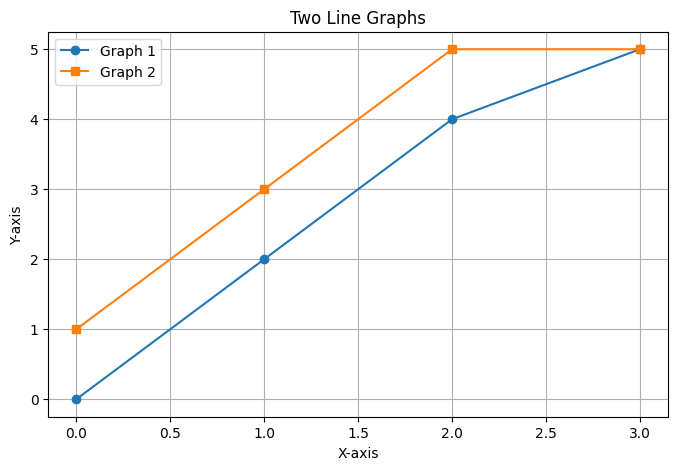

In [22]:
import matplotlib.pyplot as plt

def plot_two_graphs():
    # Graph 1 data
    x1 = [0, 1, 2, 3]
    y1 = [0, 2, 4, 5]

    # Graph 2 data
    x2 = [0, 1, 2, 3]
    y2 = [1, 3, 5, 5]

    # Create the plot
    plt.figure(figsize=(8, 5))

    plt.plot(x1, y1, label='Graph 1', marker='o')
    plt.plot(x2, y2, label='Graph 2', marker='s')

    # Add labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Two Line Graphs')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

# Call the function
plot_two_graphs()